# Group Classes Using NDVI


* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual), 
[gm_s2_semiannual](https://explorer.digitalearth.africa/gm_s2_semiannual), 
[fc_ls_summary_annual](https://explorer.digitalearth.africa/fc_ls_summary_annual),


## Background

## Description


---

## Getting Started

To run this analysis, run all the cells in the notebook, starting with the "**Load packages**" cell.

### Load packages

In [1]:
import os
import pickle
import pprint

import datacube
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS, Geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from random_sampling import random_sampling

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:36701 Dashboard: /user/vikinyaga@gmail.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `vector_file`: file path for the shapefile containing the polygon for the boundary of the area of interest
* `attribute_col`: The column in the "vector_file" containing the names of the 'urban commune' or FR 'commune urbaine', 'rural commune' or FR 'commune rurale', and 'administrative post' or FR 'poste administratif'
* `output_dir` : The directory in which to store results from the analysis.
* `commune`: In this analysis, we'll select a Niger commune/administrative post, to mask the dataset and analysis.
* `no_of_clusters` : The number of clusters used in the K-Means clustering in the [previous notebook](01_unsupervised_class_identification.ipynb).
* `time_old` : This is the time period of interest from the [previous notebook](01_unsupervised_class_identification.ipynb).
* `pickled_prediction` : The file path to the pickled clustering prediction result from the [previous notebook](01_unsupervised_class_identification.ipynb).
* `time` : This is the time period of interest to load data for.
* `resolution` : The spatial resolution, in metres, to resample the satellite data to. 
* `output_crs` : The coordinate reference system that the loaded data is to be reprojected to.
* `dask_chunks`: the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory, e.g. dict(x=1000,y=1000)
* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. 'NDVI' or 'EVI'

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [3]:
vector_file = "data/boundary_data/communes_etude.geojson"
attribute_col = "NOM_COM"

# Directory to store the results.
output_dir = "results"

# Select a commune/adminstrative post, a complete list of communes/adminstrative posts is available below.
commune = "BIRNI NGAOURE"

# The number of clusters used in the K-Means clustering in the previous notebook. 
no_of_clusters = 15

# Time period of interest from the previous notebook.
time_old = "2021"

# Prediction results from the previouse notebook.
commune_name = commune.replace(" ", "_")
pickled_prediction = f"{output_dir}/{commune_name}_kmeans_{no_of_clusters}_predicted_{time_old}.pickle"

# Time period of interest.
time = ("15-10-2020", "15-02-2022")

# Resolution and CRS to reproject data to.
resolution = (-20, 20)
output_crs = "EPSG:6933"

# Size of dask chunks.
dask_chunks = {"time": 1, "x": 500, "y": 500}

veg_index = "NDVI"

### Connect to the datacube

Connect to the datacube so we can access DE Africa data. 
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app="group_classes_using_ndvi")

### Load the Niger Communes shapefile

This shapefile contains polygons for the boundaries of Niger communes and will allows us to calculate ..  within a chosen commune/adminstrative post.

In [5]:
# Load the shapefile for the area of interest as a GeoDataFrame.
niger_communes = gpd.read_file(vector_file)
niger_communes.explore()

### List communes

You can change the `commune` in the analysis parameters cell to any Niger commune/administrative post. 
A complete list is printed below.


In [6]:
print(np.unique(niger_communes[attribute_col]))

['BIRNI NGAOURE' 'FABIDJI' 'FAKARA' 'HARIKANASSOU' 'KANKANDI' 'KIOTA'
 'KOYGOLO' 'NGONGA' 'TAGAZAR']


### Setup polygon

The commune selected needs to be transformed into a geometry object to be used in the `dc.load()` function.

In [7]:
idx = niger_communes[niger_communes[attribute_col] == commune].index[0]
geom = Geometry(geom=niger_communes.iloc[idx].geometry, crs=niger_communes.crs)

## Read in pickled K-means Clustering  prediction results from previous notebook

In [8]:
# Read in the pickled prediction data as a dictionary.
with open(pickled_prediction, "rb") as f:
    x_val, y_val, pred_val, pred_crs = pickle.load(f)

In [9]:
# Format the loaded prediction data into an xarray.DataArray.
predicted = xr.DataArray(
    data=pred_val,
    dims=["y", "x"],
    coords=dict(
        x=x_val,
        y=y_val,
    ),
    attrs=dict(
        crs=pred_crs,
    ),
).transpose("y", "x")

print(predicted)

<xarray.DataArray (y: 1578, x: 1282)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 2.636e+05 2.636e+05 2.637e+05 ... 2.892e+05 2.892e+05
  * y        (y) float64 1.67e+06 1.669e+06 1.669e+06 ... 1.638e+06 1.638e+06
Attributes:
    crs:      EPSG:6933


## Compute NDVI profiles for each pixel over the last 12 months

In [10]:
# Generate a datacube query object from the analysis parameters above.
query = {
    "geopolygon": geom,
    "time": time,
    "resolution": resolution,
    "output_crs": output_crs,
    "dask_chunks": dask_chunks,
}

In [11]:
# Load the Sentinel-2 product.
ds_s2 = load_ard(
    dc=dc,
    products=["s2_l2a"],
    measurements=["red", "nir"],
    mask_filters=[("opening", 3), ("dilation", 3)],
    **query,
    verbose=False
)

print(ds_s2)

<xarray.Dataset>
Dimensions:      (time: 96, y: 1578, x: 1282)
Coordinates:
  * time         (time) datetime64[ns] 2020-10-15T10:27:28 ... 2022-02-12T10:...
  * y            (y) float64 1.67e+06 1.669e+06 ... 1.638e+06 1.638e+06
  * x            (x) float64 2.636e+05 2.636e+05 ... 2.892e+05 2.892e+05
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


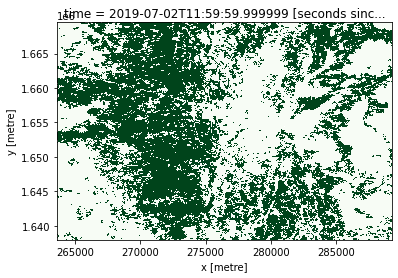

In [12]:
# Update the query as the crop-mask is only available for the year 2019.
query.update({'time' : '2019'})

# Now load the crop-mask using the query.
cm = dc.load(product='crop_mask',
             measurements=['filtered'],
             **query).filtered.squeeze()

cm.where(cm<255).plot.imshow(cmap='Greens', add_colorbar=False); # we filter to <255 to omit missing data

In [13]:
# Filter out the no data (255) and non-crop (0) pixels from the crop-mask `filtered` band and
# mask the Sentinel-2 data.
ds_s2 = ds_s2.where(cm == 1)

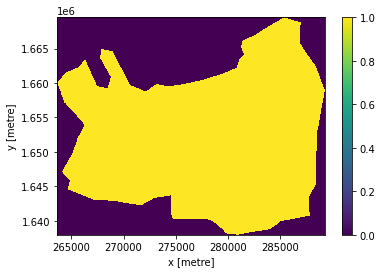

In [14]:
# Rasterize the commune polygon so the `ds_s2` dataset is masked within that raster.
niger_communes = niger_communes.to_crs(output_crs)

mask = xr_rasterize(niger_communes[niger_communes[attribute_col] == commune], ds_s2)

# Plot the mask.
mask.plot();

In [15]:
# Mask the Sentinel-2 data using the commmune polygon.
ds_s2 = ds_s2.where(mask)

In [16]:
# Calculate the 'veg_index'.
ds_s2 = calculate_indices(ds_s2, index=veg_index, collection="s2")

## Compute NDVI time series per k-means class

In [17]:
%%time
def get_timeseries(ndvi_xr, kmeans_xr, class_id):

    resample_period = "2W"
    window = 4

    ds_ndvi_class = ndvi_xr.where(kmeans_xr == class_id)

    # Smooth the NDVI over time
    ds_smooth = (
        ds_ndvi_class[veg_index]
        .resample(time=resample_period)
        .median()
        .rolling(time=window, min_periods=1)
        .mean()
    )

    timeseries = ds_smooth.mean(dim=("x", "y")).load()
    timeseries = timeseries.rename(f"Class_{class_id}")

    return timeseries


classes = np.unique(predicted)
classes = classes[~np.isnan(classes)].astype(int)

timeseries_list = []
for class_id in tqdm(classes):

    timeseries_xr = get_timeseries(ds_s2, predicted, class_id)
    timeseries_list.append(timeseries_xr)

timeseries_xr = xr.merge(timeseries_list)

100%|██████████| 15/15 [51:05<00:00, 204.36s/it]

CPU times: user 5min 51s, sys: 35.1 s, total: 6min 27s
Wall time: 51min 5s


In [18]:
# Convert from xarray.Dataset to pandas Dataframe.
timeseries_df = timeseries_xr.to_dataframe().drop(["spatial_ref"], axis=1)

In [19]:
# Save the pandas Dataframe as csv.
timeseries_df.to_csv(
    f"{output_dir}/{commune_name}_ndvitimeseries_18month_{no_of_clusters}classes.csv"
)

## Compute cross-correlation (Pearson Correlation) and keep maximum

In [20]:
def max_lagged_correlation(df, max_lag):
    max_lagged_correlation = pd.DataFrame.from_dict(
        {
            x: [
                max(df[x].corr(df[y].shift(-t)) for t in range(-max_lag, max_lag))
                for y in list(df.columns)
            ]
            for x in list(df.columns)
        }
    )

    return max_lagged_correlation

In [21]:
# Demean the time series NDVI before cross correlation.
demeaned_timeseries_df = timeseries_df.sub(timeseries_df.mean())

In [22]:
correlation_matrix_df = max_lagged_correlation(demeaned_timeseries_df, 3)
correlation_matrix_df.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
0,1.000000,0.993962,0.973669,0.870853,0.876912,0.971994,0.980424,0.970558,0.976594,0.967434,0.961153,0.961530,0.978178,0.974158,0.972149
1,0.993962,1.000000,0.966348,0.880386,0.890802,0.974882,0.988248,0.973063,0.980029,0.961227,0.942068,0.973088,0.977323,0.970259,0.979563
2,0.973669,0.966348,1.000000,0.834596,0.875326,0.991069,0.968711,0.927095,0.972992,0.929930,0.988348,0.956593,0.970562,0.987096,0.931534
3,0.801626,0.808624,0.834596,1.000000,0.936033,0.864273,0.865642,0.840726,0.861563,0.880995,0.824725,0.861607,0.890721,0.884897,0.836516
4,0.761423,0.765596,0.846294,0.936033,1.000000,0.864307,0.848228,0.761950,0.847549,0.817639,0.845808,0.870919,0.861564,0.873235,0.760770


## Identify Grouped Classes and Loner Classes

Grouped classes are the classes in the K_means clustering prediction image that were grouped together.

The loner classes are classes in the K_means clustering prediction image that were unable to be grouped in any way.

In [23]:
correlation_matrix_df_copy = correlation_matrix_df.copy()

grouped_classes = []
loner_classes = []

class_cols = list(correlation_matrix_df_copy.columns)

for i, column in enumerate(class_cols):

    thresh = 0.93

    single_class = correlation_matrix_df_copy[column]
    indexes_above_thresh = list(single_class[single_class >= thresh].index)

    correlation_matrix_df_copy = correlation_matrix_df_copy.drop(
        indexes_above_thresh, axis=0
    )

    # if not empty (contains at least one element)
    if len(indexes_above_thresh) == 1:
        loner_classes.extend(indexes_above_thresh)
    elif len(indexes_above_thresh) > 1:
        grouped_classes.append(indexes_above_thresh)

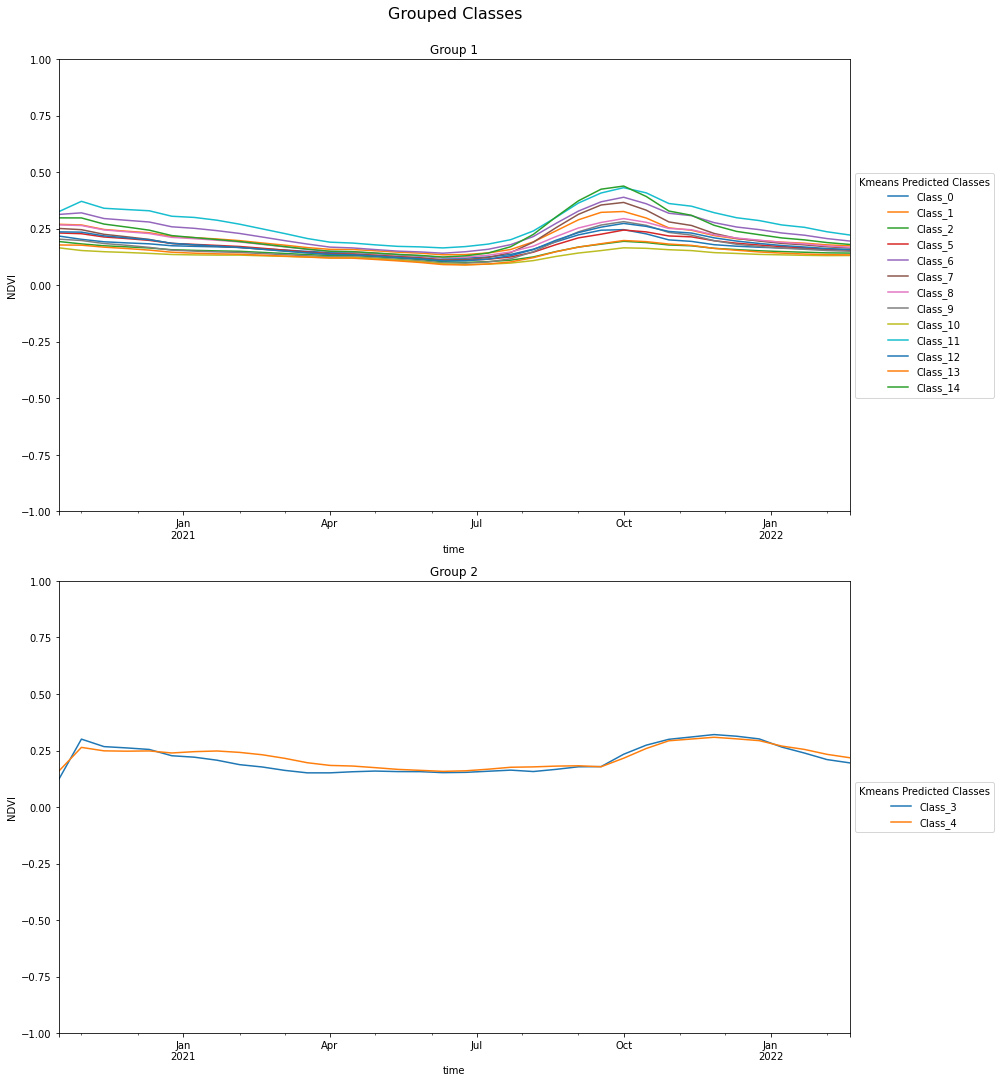

In [24]:
# Plot the grouped classes in their respective groups.
fig = plt.figure(figsize=(14, 15), facecolor="white")
fig.suptitle('Grouped Classes', x=0.455 , y=1, fontsize=16)

rows = len(grouped_classes)
columns = 1

# Starting point for naming the groups.
group_name = 1 

for i in range(rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    timeseries_df.iloc[:, grouped_classes[i]].plot(ax=ax)
    ax.legend(title= "Kmeans Predicted Classes", bbox_to_anchor=(1.0, 0.5), loc="center left")
    ax.set_ylim((-1, 1))
    ax.set_title(f"Group {group_name}")
    ax.set_ylabel("NDVI")
    group_name +=1
plt.tight_layout()

In [25]:
# Plot the loner classes. Each loner class is a group on its own.
fig = plt.figure(figsize=(14, 7), facecolor="white")
fig.suptitle('Loner (Non-Grouped) Classes', x=0.455 , y=1, fontsize=16)

rows = len(loner_classes)
columns = 1

for i in range(rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    timeseries_df.iloc[:, loner_classes[i]].plot(ax=ax)
    ax.legend(title= "Kmeans Predicted Classes",bbox_to_anchor=(1.0, 0.5), loc="center left")
    ax.set_ylim((-1, 1))
    ax.set_title(f"Group {group_name}")
    ax.set_ylabel("NDVI")
    group_name +=1

<Figure size 1008x504 with 0 Axes>

In [26]:
# Export the groups.

# Starting point for naming the groups.
group_name = 1 

for group in grouped_classes:
    class_list = [f"Class_{index}" for index in group]

    with open(
        f"{output_dir}/{commune_name}_correlated_ndvi_group{group_name}_{no_of_clusters}classes.pickle",
        "wb",
    ) as f:
        pickle.dump(class_list, f, protocol=-1)
    
    group_name+=1
        
with open(
    f"{output_dir}/{commune_name}_correlated_ndvi_singles_{no_of_clusters}classes.pickle",
    "wb",
) as f:
    pickle.dump([f"Class_{index}" for index in loner_classes], f, protocol=-1)

## Recommended next steps

To continue working through the notebooks in this workflow, go to the next notebook `02_group_classes_using_NDVI.ipynb`.

1. [Unsupervised Class Identification](01_unsupervised_class_identification.ipynb)
2. **Group Classes Using NDVI (this notebook)**
3. [Reclassify Unsupervised NDVI](03_reclassify_unsupervised_map_NDVI_classes.ipynb)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [27]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [28]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2022-06-16'